# Analysis of Sonogashira reaction mixture: formula regression

In this notebook we will perform study of one specific ion in the spectrum, using regression model

## Import required packages

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from mass_automation.experiment import Experiment

from mass_automation.deisotoping.process import MlDeisotoper
from mass_automation.formula import RealIsotopicDistribution, ELECTRON_MASS
from mass_automation.formula.model import LSTM
from mass_automation.formula.data import pack_sequence, normalizers
from mass_automation.formula.determination import brute_force_search

from mass_automation.plot import plot_spectrum
from mass_automation.utils import ELEMENT_DICT, Element, monoisotopic

## Open the experimental data

In [2]:
exp = Experiment('../reaction_mixture.mzXML', 128, 16)

## Perform deisotoping

As a guideline, if you are interested in studying less intensive signals, select CatBoost model, if you want to analyzed only major signals, then choose XGBoost model

In [3]:
deisotoper = MlDeisotoper().load('data/models/xgb_model.pkl')
deisotoped_spectrum = deisotoper(exp[0])

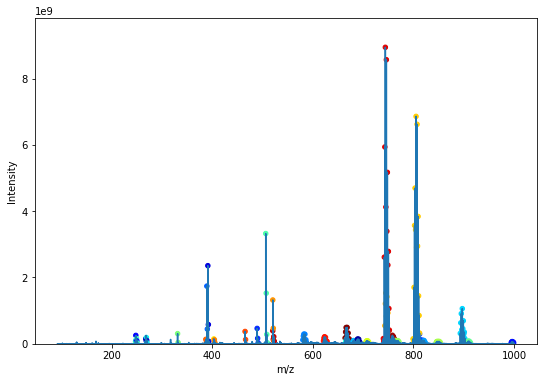

In [4]:
plot_spectrum(exp[0], labels=deisotoped_spectrum)

Let's look closer to two the most abundant Pd-complexes

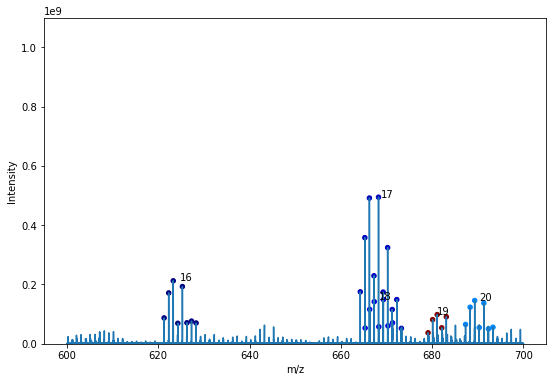

In [5]:
plot_spectrum(exp[0], labels=deisotoped_spectrum, x_left=600, x_right=700, y_max=1e9, annotate_distributions=True)

## Load the model

Here we will use the regression model to study elements present in the ions.

In [6]:
model = LSTM.load_from_checkpoint('nn_models/regression/lstm_bi_full.ckpt')
model.eval()

LSTM(
  (lstm): LSTM(100, 256, num_layers=3, dropout=0.5, bidirectional=True)
  (decoder): LinearWithHidden(
    (embedder): Sequential(
      (0): Linear(in_features=1536, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=512, out_features=119, bias=True)
    )
  )
  (loss): MSELoss()
  (train_r2): R2Score()
  (val_r2): R2Score()
  (test_r2): R2Score()
)

Let's select an isotopic distribution with mass around 750 Th

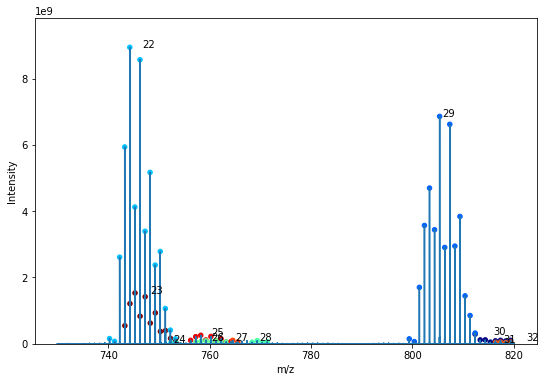

In [7]:
plot_spectrum(exp[0], labels=deisotoped_spectrum, x_left=730, x_right=820, annotate_distributions=True)

In [8]:
def get_prediction_for_ion(ion_id):
    ri = RealIsotopicDistribution(exp[0], np.where(deisotoped_spectrum == ion_id)[0])

    representations, represeantaion_masses = zip(*ri.get_representation(f=np.mean, mode='middle', length=101))
    representations_centered = []


    for representation, representaion_mass in zip(representations, represeantaion_masses):
        center = np.argmax(representation[40:60])-50+40

        centered_representation = representation
        med = np.median(centered_representation)

        centered_representation[:20] = med
        centered_representation[-20:] = med

        if center < 0:
            centered_representation = np.array([med]*(-center)+list(representation[:center]))
        else:
            centered_representation = np.array(list(representation[center:])+[med]*center)

        representations_centered.append(centered_representation-med)
        representations_centered[-1][-1] = representaion_mass/1000

    sum_ = max([item.max() for item in representations_centered])
    representations_centered = [item/sum_ for item in representations_centered]

    out = model.forward(pack_sequence([torch.FloatTensor(representations_centered)]*2)).detach().cpu().numpy()[0]
    
    return out

In [9]:
out = get_prediction_for_ion(11)

for i, value in enumerate((out * normalizers['means'](1)).round().astype(int)):
    if value != 0 and ELEMENT_DICT[i+1] not in monoisotopic:
        print(ELEMENT_DICT[i+1], value)

H 35
C 35
N 2
O 1


The correct formula for this compound if $C_{35}H_{41}N_2$, so the number of carbons and nitrogens is identified correctly, oxygen is the fals-positive prediction, and amount of hydrogen is underestimated. Overall, the algorithm significatnly reduces the search space and provides a reasonable formula.

In [10]:
out = get_prediction_for_ion(22)

for i, value in enumerate((out * normalizers['means'](1)).round().astype(int)):
    if value != 0 and ELEMENT_DICT[i+1] not in monoisotopic:
        print(ELEMENT_DICT[i+1], value)

H 42
C 30
N 2
O 5
Si 1
S 1
Pd 1


Here we don't know the correct formula for the ion, but palladium is identified correctly, Si and S are false positives. These could be easily filtered based on the data for element classification or by brute-force algorithm.

Let's see what monoisotopic elements are predicted for this isotopic distribution:

In [11]:
out = get_prediction_for_ion(22)

for i, value in enumerate((out * normalizers['means'](1)).round().astype(int)):
    if value != 0 and ELEMENT_DICT[i+1] in monoisotopic:
        print(ELEMENT_DICT[i+1], value)

F 2
P 1


The model makes a quite reasonable guess of presence of P in the ion, though it cannot infer the from isotopic distribution directly.

Let's analyze formula for the compound #11

In [12]:
ion_id = 11
out = get_prediction_for_ion(ion_id)

ELEMENTS = ['C', 'H', 'N', 'O']
DELTA = 10

# Usually, it is better to assign delta individually for each element 
# (for instance, for carbon it should be around 3, while for hydrogen, 10)

neural_formula = out[[getattr(Element, element)-1 for element in ELEMENTS]]
low_limits = np.maximum(neural_formula-DELTA, 0).round().astype(int)
high_limits = np.maximum(neural_formula+DELTA, 0).round().astype(int)

print(neural_formula)
print(low_limits)
print(high_limits)

[35.403885  35.012547   2.4167886  1.2610116]
[25 25  0  0]
[45 45 12 11]


In [13]:
distr_ints = exp[0].ints[np.where(deisotoped_spectrum == ion_id)[0]].max()
distr_masses = exp[0].masses[np.where(deisotoped_spectrum == ion_id)[0]]

total = []

# Perform search for each peak in the isotopic distribution
for mass in tqdm(distr_masses):
    total += list(brute_force_search(mass+ELECTRON_MASS, ELEMENTS, 
                                     low_limits, high_limits, exp[0], 5e-3, {},100))

In [14]:
# Sort by cosine distance
for formula, mass, cosine, delta in sorted(total,key=lambda x: x[2]):
    if delta < 3: # Filter large errors in masses (greater than 3 ppm)
        print(''.join([f"{el}{q:n}" for el, q in zip(ELEMENTS, formula) if q != 0]) + f"\t{mass:.4f}\t{cosine:.4f}\t{delta:.4f}")

C35H41N2	489.3270	0.0003	0.8873
C28H40N7O1	490.3294	0.0074	2.7642
C30H42N4O2	490.3308	0.0101	0.0259


If the assignment was performed solely based on masses an incorrect formula — $C_{30}H_{42}N_{4}O_{2}$ would be assigned. However, we compare isotopic distributions, therefore increasing the robustness of the model. Initial search space reduction using a neural network significantly decreased the number of comparisons for the brute-force search. As a result, the correct formula for $IPrH^{+}$ was assigned.